In [11]:
import argparse
import datetime
import os.path as osp
import os
from pprint import pformat
import sys
sys.path.append('.')
# import glog as log
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torchvision import transforms as t
from tensorboardX import SummaryWriter

from datasets.vggface2 import VGGFace2
# from datasets.vggface2flip import VGGFace2Flip

from losses.am_softmax import AMSoftmaxLoss
# from evaluate_lfw import evaluate, compute_embeddings_lfw

from utils.utils import load_model_state, save_model_cpu
import utils.augmentation as augm
from utils.parser_yaml import ArgumentParserWithYaml
from evaluate import evaluate, compute_embeddings_lfw

from datasets.twins import TwinPairsDataset, ClassificationDataset
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES']='0,1,2'

In [ ]:
VGGFace2_ROOT = '/home//user/data/vgg_face2'
LFW_ROOT = '/home//user/data/lfw'
TWINS_ROOT = '/home/user/data/twins_aligned_eyes_resized'

In [89]:
class Args:
    #datasets configuration
    train_dataset='vgg'
    train_data_root=f'{VGGFace2_ROOT}/train'
    train_list=f'{VGGFace2_ROOT}/train_list.txt'
    train_landmarks=f'{VGGFace2_ROOT}/bb_landmark'

    val_data_root=f'{LFW_ROOT}/lfw-deepfunneled'
    val_step=50
    val_list=f'{LFW_ROOT}/pairs.txt'
    val_landmarks=f'{LFW_ROOT}/lfw_landmark.txt'

    #model configuration
    model='mobilenet'
    embed_size=256

    #optimizer configuration
    train_batch_size=80
    epoch_total_num=3000
    lr=0.35
    momentum=0.9
    weight_decay=0.0001

    #loss configuration
    mining_type='focal'
    t=1.1
    gamma=2.
    m=1.0
    s=30
    margin_type='cos'

    #other parameters
    devices=[0,1,2]
    val_batch_size=20
    snap_folder='./snapshots/'
    snap_prefix='res18_224_twins_rot'
    snap_to_resume= 'snapshots/res18_224_twins_rot0.9076_0.7436507936507936.pt'
    weighted=True
args = Args()

In [41]:
torch.cuda.device_count()

3

### Data

In [61]:
# input_size = models_backbones[args.model].get_input_res()

from albumentations import Compose, Normalize, CenterCrop, Resize
from albumentations.torch import ToTensor

DF_ROOT='/home/user/data/twins_aligned_cropped_resized'
# define crop transform of your choice
crop = 512
input_size = (320,320)
# center crop + normalize
transform = Compose([
#     CenterCrop(crop, crop),
                     Resize(*input_size)],
#                      Normalize(mean, std)], 
                   to_tensor=ToTensor())#, additional_targets={'image1': 'image'})
#                    keypoint_params={'format': 'xy', 'remove_invisible': False})
# transform = Compose([CenterCrop(size, size), ToTensor()], p=1,
#         additional_targets={'image1': 'image'})

# front images for each id
views = pd.read_csv(os.path.join(DF_ROOT, 'df', 'views.csv'), index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv(os.path.join(DF_ROOT, 'df', 'pairs_test_fedor.csv'))
pairs['id_1'] = pairs['id_1'].astype(int)
pairs['id_2'] = pairs['id_2'].astype(int)

lfw = TwinPairsDataset(TWINS_ROOT, pairs, views, transform=transform, keypoints=True)#, landmarks=True)
print(len(lfw))

277


In [62]:
pairst = pd.read_csv(os.path.join(DF_ROOT, 'df', 'pairs_train_fedor.csv'))
pairst['id_1'] = pairst['id_1'].astype(int)
pairst['id_2'] = pairst['id_2'].astype(int)

In [63]:
pairs[pairs.label=='Same'].shape, len(np.intersect1d(pairst.id_1, pairs.id_1)), len(np.unique(pairs.id_1))

((149, 3), 0, 149)

In [64]:
pairst.head()

,id_1,id_2,label
0,90360,90361,IdenticalTriplet
1,90360,90362,IdenticalTriplet
2,90361,90360,IdenticalTriplet
3,90361,90362,IdenticalTriplet
4,90362,90360,IdenticalTriplet


In [65]:
views_train = views[views.subject_id.isin(pairst.id_1)]
views_train['label']=range(views_train.shape[0])
views_train.index = views_train.index.astype(str)
views_train.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(286, 3)

In [66]:
# views_train = views[~views.subject_id.isin(pairs.id_1)]
# views_train['label']=range(views_train.shape[0])
# views_train = pd.read_csv(os.path.join(DF_ROOT, 'df', 'views_train_face.csv'), index_col=0)
# views_train.index = views_train.index.astype(str)
# views_train.filename = views_train.filename.apply(eval)

dataset = ClassificationDataset(TWINS_ROOT, views_train, transform, keypoints=True)#, landmarks=True)
print(len(dataset))
train_loader = DataLoader(dataset, batch_size=args.train_batch_size, num_workers=4, shuffle=True)

1716


In [67]:
# dataset = VGGFace2(args.train_data_root, args.train_list, args.train_landmarks)

# if dataset.have_landmarks:
#     print('Use alignment for the train data')
#     dataset.transform = t.Compose([
# #         augm.HorizontalFlipNumpy(p=.5),
#                                    augm.CutOutWithPrior(p=0.05, max_area=0.1),
#                                    augm.RandomRotationNumpy(10, p=.95),
#                                    augm.ResizeNumpy(input_size),
#                                    augm.BlurNumpy(k=5, p=.2),
#                                    augm.NumpyToTensor(switch_rb=True)])
# else:
#     dataset.transform = t.Compose([augm.ResizeNumpy(input_size),
# #                                    augm.HorizontalFlipNumpy(),
#                                    augm.RandomRotationNumpy(10),
#                                    augm.NumpyToTensor(switch_rb=True)])

# if args.weighted:
#     train_weights = dataset.get_weights()
#     train_weights = torch.DoubleTensor(train_weights)
#     sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, len(train_weights))
#     train_loader = torch.utils.data.DataLoader(dataset, batch_size=args.train_batch_size,
#                                                sampler=sampler, num_workers=3, pin_memory=False)
# else:
#     train_loader = DataLoader(dataset, batch_size=args.train_batch_size, num_workers=4, shuffle=True)

# # lfw = LFW(args.val_data_root, args.val_list, args.val_landmarks)
# # if lfw.use_landmarks:
# #     print('Use alignment for the test data')
# #     lfw.transform = t.Compose([augm.ResizeNumpy(input_size),
# #                                augm.NumpyToTensor(switch_rb=True)])
# # else:
# #     lfw.transform = t.Compose([augm.ResizeNumpy((160, 160)),
# #                                augm.CenterCropNumpy(input_size),
# #                                augm.NumpyToTensor(switch_rb=True)])


In [68]:
# len(dataset.identities), len(dataset.samples_info)

In [69]:
import cv2

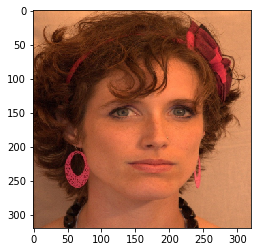

In [70]:
sample = dataset[70]['img']
# f,a = plt.subplots(1,2)
plt.imshow(sample.numpy().transpose(1,2,0))
# a[1].imshow(sample[3:].numpy().transpose(1,2,0))

In [71]:
log_path = './logs/{:%Y_%m_%d_%H_%M}_{}'.format(datetime.datetime.now(), args.snap_prefix)
print(log_path)
# os.makedirs(log_path, exist_ok=True)
writer = SummaryWriter(log_path)

if not osp.exists(args.snap_folder):
    os.mkdir(args.snap_folder)

./logs/2019_05_31_04_34_res18_224_twins_rot


In [72]:
args.devices

[0, 1, 2]

### Model

In [73]:
from model.resnet_angular import ResNetAngular, ResNetAngularKP
from torchvision.models import resnet50, resnet18

import torch.nn as nn
import torch

In [74]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

backbone = resnet18(pretrained=True)
backbone.avgpool = nn.AdaptiveAvgPool2d(1)
# conv_weight = backbone.state_dict()['conv1.weight']
# backbone.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# backbone.conv1.weight.data=torch.cat([conv_weight, conv_weight], 1)
backbone.fc = Identity()

In [75]:
model = ResNetAngular(backbone, embedding_size=512, num_classes=dataset.get_num_classes(), feature=False)

In [90]:
# model = models_backbones[args.model](embedding_size=args.embed_size,
#                                          num_classes=dataset.get_num_classes(), feature=False)
if args.snap_to_resume is not None:
    print('Resuming snapshot ' + args.snap_to_resume + ' ...')
    model = load_model_state(model, args.snap_to_resume, args.devices[0], eval_state=False)
    model = torch.nn.DataParallel(model, device_ids=args.devices)
else:
    model = torch.nn.DataParallel(model, device_ids=args.devices, output_device=args.devices[0])
    model.cuda()
    model.train()
    cudnn.benchmark = True

# print('Face Recognition model:')
# print(model)

Resuming snapshot snapshots/res18_224_twins_rot0.9076_0.7436507936507936.pt ...


In [77]:
if args.mining_type == 'focal':
    softmax_criterion = AMSoftmaxLoss(gamma=args.gamma, m=args.m, margin_type=args.margin_type, s=args.s)
else:
    softmax_criterion = AMSoftmaxLoss(t=args.t, m=0.35, margin_type=args.margin_type, s=args.s)
aux_losses = MetricLosses(dataset.get_num_classes(), args.embed_size, writer)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [3, 6, 9, 13])

In [78]:
sample = next(iter(train_loader))
sample_val =lfw[0]
sample.keys(), sample_val.keys()

(dict_keys(['img', 'label', 'instance', 'kp']),
 dict_keys(['img1', 'img2', 'is_same', 'id0', 'id1', 'kp1', 'kp2']))

In [79]:
best_auc=0

for epoch_num in range(args.epoch_total_num):
    scheduler.step()
    if epoch_num > 6:
        model.module.set_dropout_ratio(0.)
    classification_correct = 0
    classification_total = 0

    for i, data in enumerate(train_loader, 0):
        iteration = epoch_num * len(train_loader) + i

        if iteration % args.val_step == 0:
#             snapshot_name = osp.join(args.snap_folder, args.snap_prefix + '_{0}.pt'.format(iteration))
#             if iteration > 0:
#                 print('Saving Snapshot: ' + snapshot_name)
#                 save_model_cpu(model, optimizer, snapshot_name, epoch_num)

#             print('Evaluating Snapshot: ' + snapshot_name)
            model.eval()
            same_acc, diff_acc, all_acc, auc, t = evaluate(args, lfw, model, compute_embeddings_lfw,
                                                        args.val_batch_size, verbose=False)
            if auc>best_auc and same_acc>0.65 and diff_acc>0.65:
                best_auc = auc
                snapshot_name = osp.join(args.snap_folder, args.snap_prefix + f'{auc:.4f}_{all_acc}.pt')
                print('Saving Snapshot: ' + snapshot_name)
                save_model_cpu(model, optimizer, snapshot_name, epoch_num)

            model.train()

            print('Validation accuracy: {0:.4f}, {1:.4f}'.format(same_acc, diff_acc))
            print('Validation accuracy mean: {0:.4f}, {1:.4f}'.format(all_acc, t))
            print('Validation AUC: {0:.4f}'.format(auc))
            writer.add_scalar('Accuracy/Val_same_accuracy', same_acc, iteration)
            writer.add_scalar('Accuracy/Val_diff_accuracy', diff_acc, iteration)
            writer.add_scalar('Accuracy/Val_accuracy', all_acc, iteration)
            writer.add_scalar('Accuracy/AUC', auc, iteration)

        data, label = data['img'], data['label'].cuda()
#         data, label, kp = data['img'], data['label'].cuda(), data['kp'].cuda()
#         kp = data['kp'].cuda()
        features, sm_outputs = model(data)
#         features, sm_outputs = model(data, kp)

        optimizer.zero_grad()
        aux_losses.init_iteration()
        aux_loss, aux_log = aux_losses(features, label, epoch_num, iteration)
        loss_sm = softmax_criterion(sm_outputs, label)
        loss = loss_sm + aux_loss
        loss.backward()
        aux_losses.end_iteration()
        optimizer.step()

        _, predicted = torch.max(sm_outputs.data, 1)
        classification_total += int(label.size(0))
        classification_correct += int(torch.sum(predicted.eq(label)))
        train_acc = float(classification_correct) / classification_total

        if i % 10 == 0:
            print('Iteration %d, Softmax loss: %.4f, Total loss: %.4f, Acc: %.4f' % (iteration, loss_sm, loss, train_acc) + aux_log)
#             print('Learning rate: %f' % scheduler.get_lr()[0])
            writer.add_scalar('Loss/train_loss', loss, iteration)
            writer.add_scalar('Loss/softmax_loss', loss_sm, iteration)
#             writer.add_scalar('Learning_rate', scheduler.get_lr()[0], iteration)
            writer.add_scalar('Accuracy/classification', train_acc, iteration)

Computing embeddings: 100%|██████████| 14/14 [00:02<00:00,  3.78it/s]


Validation accuracy: 0.8176, 0.3225
Validation accuracy mean: 0.5652, 0.0621
Validation AUC: 0.7704
Iteration 0, Softmax loss: 36.2142, Total loss: 36.2142, Acc: 0.0000
Iteration 10, Softmax loss: 35.1943, Total loss: 35.1943, Acc: 0.0398
Iteration 20, Softmax loss: 33.8788, Total loss: 33.8788, Acc: 0.1268
Iteration 22, Softmax loss: 33.4258, Total loss: 33.4258, Acc: 0.4875
Iteration 32, Softmax loss: 32.4145, Total loss: 32.4145, Acc: 0.6102
Iteration 42, Softmax loss: 31.0911, Total loss: 31.0911, Acc: 0.6911
Iteration 44, Softmax loss: 30.5024, Total loss: 30.5024, Acc: 0.9500


Computing embeddings: 100%|██████████| 14/14 [00:01<00:00,  7.79it/s]


Validation accuracy: 0.8247, 0.5451
Validation accuracy mean: 0.6779, 0.1183
Validation AUC: 0.8635
Iteration 54, Softmax loss: 30.6102, Total loss: 30.6102, Acc: 0.9080
Iteration 64, Softmax loss: 29.8064, Total loss: 29.8064, Acc: 0.9214
Iteration 66, Softmax loss: 28.7956, Total loss: 28.7956, Acc: 0.9375
Iteration 76, Softmax loss: 28.6760, Total loss: 28.6760, Acc: 0.9591
Iteration 86, Softmax loss: 28.6995, Total loss: 28.6995, Acc: 0.9589
Iteration 88, Softmax loss: 28.8857, Total loss: 28.8857, Acc: 0.9500
Iteration 98, Softmax loss: 28.5176, Total loss: 28.5176, Acc: 0.9716


Computing embeddings: 100%|██████████| 14/14 [00:01<00:00,  7.70it/s]


Validation accuracy: 0.8242, 0.5445
Validation accuracy mean: 0.6776, 0.1246
Validation AUC: 0.8950
Iteration 108, Softmax loss: 28.6973, Total loss: 28.6973, Acc: 0.9714
Iteration 110, Softmax loss: 28.3425, Total loss: 28.3425, Acc: 0.9625
Iteration 120, Softmax loss: 28.3296, Total loss: 28.3296, Acc: 0.9693
Iteration 130, Softmax loss: 28.4048, Total loss: 28.4048, Acc: 0.9720
Iteration 132, Softmax loss: 28.2254, Total loss: 28.2254, Acc: 0.9625
Iteration 142, Softmax loss: 28.3681, Total loss: 28.3681, Acc: 0.9784


Computing embeddings: 100%|██████████| 14/14 [00:01<00:00,  7.79it/s]


Validation accuracy: 0.8621, 0.5824
Validation accuracy mean: 0.7144, 0.1271
Validation AUC: 0.9046
Iteration 152, Softmax loss: 28.4219, Total loss: 28.4219, Acc: 0.9810
Iteration 154, Softmax loss: 28.2916, Total loss: 28.2916, Acc: 0.9625
Iteration 164, Softmax loss: 28.5160, Total loss: 28.5160, Acc: 0.9716
Iteration 174, Softmax loss: 28.3796, Total loss: 28.3796, Acc: 0.9756
Iteration 176, Softmax loss: 28.6161, Total loss: 28.6161, Acc: 0.9625
Iteration 186, Softmax loss: 28.5396, Total loss: 28.5396, Acc: 0.9784
Iteration 196, Softmax loss: 28.7067, Total loss: 28.7067, Acc: 0.9815


Computing embeddings:   0%|          | 0/14 [00:00<?, ?it/s]

Iteration 198, Softmax loss: 28.7271, Total loss: 28.7271, Acc: 0.9750


Computing embeddings: 100%|██████████| 14/14 [00:01<00:00,  7.92it/s]


Validation accuracy: 0.8181, 0.6418
Validation accuracy mean: 0.7218, 0.1220
Validation AUC: 0.9055
Iteration 208, Softmax loss: 28.4998, Total loss: 28.4998, Acc: 0.9773
Iteration 218, Softmax loss: 27.9662, Total loss: 27.9662, Acc: 0.9750
Iteration 220, Softmax loss: 28.3944, Total loss: 28.3944, Acc: 0.9875
Iteration 230, Softmax loss: 28.8077, Total loss: 28.8077, Acc: 0.9795
Iteration 240, Softmax loss: 28.1741, Total loss: 28.1741, Acc: 0.9804
Iteration 242, Softmax loss: 28.6155, Total loss: 28.6155, Acc: 0.9625


Computing embeddings: 100%|██████████| 14/14 [00:01<00:00,  7.65it/s]


Validation accuracy: 0.9055, 0.5198
Validation accuracy mean: 0.7061, 0.1349
Validation AUC: 0.9067
Iteration 252, Softmax loss: 28.0115, Total loss: 28.0115, Acc: 0.9761
Iteration 262, Softmax loss: 27.7276, Total loss: 27.7276, Acc: 0.9786
Iteration 264, Softmax loss: 28.2221, Total loss: 28.2221, Acc: 0.9875
Iteration 274, Softmax loss: 28.2322, Total loss: 28.2322, Acc: 0.9807
Iteration 284, Softmax loss: 28.1656, Total loss: 28.1656, Acc: 0.9768
Iteration 286, Softmax loss: 28.6894, Total loss: 28.6894, Acc: 0.9750
Iteration 296, Softmax loss: 28.1912, Total loss: 28.1912, Acc: 0.9830


Computing embeddings: 100%|██████████| 14/14 [00:01<00:00,  6.28it/s]


Validation accuracy: 0.9126, 0.4181
Validation accuracy mean: 0.6593, 0.1372
Validation AUC: 0.9052
Iteration 306, Softmax loss: 27.7857, Total loss: 27.7857, Acc: 0.9827
Iteration 308, Softmax loss: 28.1051, Total loss: 28.1051, Acc: 0.9875
Iteration 318, Softmax loss: 28.4696, Total loss: 28.4696, Acc: 0.9818
Iteration 328, Softmax loss: 27.8768, Total loss: 27.8768, Acc: 0.9774
Iteration 330, Softmax loss: 27.9967, Total loss: 27.9967, Acc: 0.9625
Iteration 340, Softmax loss: 28.2105, Total loss: 28.2105, Acc: 0.9750


Computing embeddings: 100%|██████████| 14/14 [00:01<00:00,  7.77it/s]


Validation accuracy: 0.7445, 0.6319
Validation accuracy mean: 0.6813, 0.1173
Validation AUC: 0.9041
Iteration 350, Softmax loss: 27.7099, Total loss: 27.7099, Acc: 0.9810
Iteration 352, Softmax loss: 28.2337, Total loss: 28.2337, Acc: 0.9625
Iteration 362, Softmax loss: 28.2789, Total loss: 28.2789, Acc: 0.9773
Iteration 372, Softmax loss: 28.7342, Total loss: 28.7342, Acc: 0.9768
Iteration 374, Softmax loss: 28.1521, Total loss: 28.1521, Acc: 1.0000
Iteration 384, Softmax loss: 28.2667, Total loss: 28.2667, Acc: 0.9693
Iteration 394, Softmax loss: 27.9574, Total loss: 27.9574, Acc: 0.9780
Iteration 396, Softmax loss: 28.4231, Total loss: 28.4231, Acc: 0.9125


Computing embeddings: 100%|██████████| 14/14 [00:01<00:00,  7.66it/s]


Validation accuracy: 0.8016, 0.6335
Validation accuracy mean: 0.7103, 0.1217
Validation AUC: 0.9024
Iteration 406, Softmax loss: 28.3641, Total loss: 28.3641, Acc: 0.9727
Iteration 416, Softmax loss: 28.2857, Total loss: 28.2857, Acc: 0.9756


Process Process-317:
Process Process-319:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-320:
Traceback (most recent call last):
Process Process-318:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/pyth

KeyboardInterrupt: 

In [80]:
model.eval()
same_acc, diff_acc, all_acc, auc,t = evaluate(args, lfw, model, compute_embeddings_lfw, 1, verbose=True)

 evaluation: 100%|██████████| 10/10 [00:00<00:00, 30.36it/s]

Accuracy/Val_same_accuracy mean: 0.8033
Accuracy/Val_diff_accuracy mean: 0.6198
Accuracy/Val_accuracy mean: 0.7037
Accuracy/Val_accuracy std dev: 0.0932
AUC: 0.8917
Estimated threshold: 0.1206


In [92]:
model.eval()

DataParallel(
  (module): DataParallel(
    (module): ResNetAngular(
      (model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [93]:
scores_with_gt = compute_embeddings_lfw(args, lfw, model, 1, dump_embeddings=False)

Computing embeddings: 100%|██████████| 277/277 [00:05<00:00, 48.96it/s]


In [94]:
from sklearn.metrics import roc_auc_score

In [98]:
roc_auc_score(gt, 1-np.array(scores))

0.8269714765100671

In [96]:
scores = [s['score'] for s in scores_with_gt]
gt = [s['is_same'].item() for s in scores_with_gt]

In [97]:
((np.array(scores)<t).astype(int)==gt).mean()

0.7364620938628159

In [88]:
t

0.1222553

False


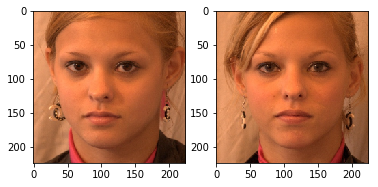

In [60]:
sample = twins_dataset[532]
fig, axs = plt.subplots(1,2)
print(sample['is_same'])
axs[0].imshow(sample['img1'].numpy().transpose(1,2,0))
axs[1].imshow(sample['img2'].numpy().transpose(1,2,0))

In [32]:
from tqdm import tqdm_notebook as tqdm

In [39]:
model.eval()

DataParallel(
  (module): DataParallel(
    (module): ResNetAngular(
      (model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [40]:
def get_embeddings(dataset, model, features_dim=512):
    labels = []
    embeddings = np.zeros((len(dataset), 2*features_dim))
    keypoints = np.zeros((len(dataset), 4*68))
    for i, sample in tqdm(enumerate(dataset), total = len(dataset)):
        img1 = sample['img1'][None, :].cuda()
        img2 = sample['img2'][None, :].cuda()
        labels.append(int(sample['is_same']))
        
        keypoints[i, :] = np.concatenate([sample['kp1'].flatten(), sample['kp2'].flatten()])
        with torch.no_grad():
            emb1 = model(img1)
            emb2 = model(img2)
            embeddings[i,:] = torch.cat([emb1, emb2],-1).detach().cpu().numpy()
    return embeddings, keypoints, labels

In [41]:
views = pd.read_csv(os.path.join(DF_ROOT, 'df', 'views.csv'), index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

transform = Compose([
#     CenterCrop(crop, crop),
                     Resize(*input_size)],
#                      Normalize(mean, std)], 
                   to_tensor=ToTensor())#, additional_targets={'image1': 'image'})

# pairs including 50% of same identities
pairs = pd.read_csv(os.path.join(DF_ROOT, 'df', 'pairs_train_fedor.csv'))
pairs['id_1'] = pairs['id_1'].astype(int)
pairs['id_2'] = pairs['id_2'].astype(int)

train_dataset = TwinPairsDataset(TWINS_ROOT, pairs, views, transform=transform, keypoints=True)#, landmarks=True)

In [42]:
views = pd.read_csv(os.path.join(DF_ROOT, 'df', 'views.csv'), index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv(os.path.join(DF_ROOT, 'df', 'pairs_test_fedor.csv'))
pairs['id_1'] = pairs['id_1'].astype(int)
pairs['id_2'] = pairs['id_2'].astype(int)

lfw = TwinPairsDataset(TWINS_ROOT, pairs, views, transform=transform, keypoints=True)#, landmarks=True)
print(len(lfw))

277


In [43]:
train_embeddings, train_keypoints, train_labels = get_embeddings(train_dataset, model)

In [44]:
train_embeddings.shape, train_keypoints.shape, len(train_labels), train_labels[:5]

((573, 1024), (573, 272), 573, [0, 0, 0, 0, 0])

In [45]:
test_embeddings, test_keypoints, test_labels = get_embeddings(lfw, model)

In [46]:
test_embeddings.shape, test_keypoints.shape, len(test_labels), test_labels[-5:]

((277, 1024), (277, 272), 277, [1, 1, 1, 1, 1])

In [47]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,roc_auc_score,recall_score,precision_score

In [40]:
X_train = np.concatenate([train_embeddings, train_keypoints],-1)
X_test = np.concatenate([test_embeddings, test_keypoints],-1)

In [49]:
svc = SVC(kernel='linear', C=1, probability=True)
svc.fit(train_embeddings, train_labels)
preds = svc.predict_proba(test_embeddings)
print(roc_auc_score(test_labels, preds[:,1]))

svc.score(test_embeddings, test_labels)

0.5304635067114093


0.4584837545126354

In [50]:
import lightgbm as lgb

In [51]:
model = lgb.LGBMClassifier(max_depth=12, learning_rate=0.01)

In [52]:
model.fit(train_embeddings, train_labels, eval_set = (test_embeddings, test_labels), eval_metric='auc')

[1]	valid_0's binary_logloss: 0.693622	valid_0's auc: 0.565017
[2]	valid_0's binary_logloss: 0.694081	valid_0's auc: 0.513239
[3]	valid_0's binary_logloss: 0.694163	valid_0's auc: 0.505899
[4]	valid_0's binary_logloss: 0.694267	valid_0's auc: 0.502045
[5]	valid_0's binary_logloss: 0.693676	valid_0's auc: 0.532194
[6]	valid_0's binary_logloss: 0.694268	valid_0's auc: 0.508127
[7]	valid_0's binary_logloss: 0.694571	valid_0's auc: 0.495805
[8]	valid_0's binary_logloss: 0.694739	valid_0's auc: 0.491742
[9]	valid_0's binary_logloss: 0.695372	valid_0's auc: 0.477795
[10]	valid_0's binary_logloss: 0.695575	valid_0's auc: 0.47554
[11]	valid_0's binary_logloss: 0.695813	valid_0's auc: 0.476169
[12]	valid_0's binary_logloss: 0.6961	valid_0's auc: 0.470795
[13]	valid_0's binary_logloss: 0.696371	valid_0's auc: 0.471109
[14]	valid_0's binary_logloss: 0.696117	valid_0's auc: 0.474308
[15]	valid_0's binary_logloss: 0.69597	valid_0's auc: 0.474255
[16]	valid_0's binary_logloss: 0.696268	valid_0's auc

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=12,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)